## Overview

1. Exploring the Data
2. __Logistic Regression__
3. CNN
4. Building Test Functions

In this section, I take a build a logistic regression model and analyze the results.  Building a Logistic Regression model gives me a quick way to build a baseline model.

In [1]:
import numpy as np
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, KernelPCA
from tempfile import mkdtemp
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the data

In [2]:
#get path names
path = r'/Users/john/Desktop/Demo_Day/Data/npy'
file_names = sorted(glob.glob(path +'/*.npy'))
file_names 


['/Users/john/Desktop/Demo_Day/Data/npy/full_numpy_bitmap_angel.npy',
 '/Users/john/Desktop/Demo_Day/Data/npy/full_numpy_bitmap_sword.npy',
 '/Users/john/Desktop/Demo_Day/Data/npy/full_numpy_bitmap_wine_glass.npy',
 '/Users/john/Desktop/Demo_Day/Data/npy/full_numpy_bitmap_yoga.npy']

In [3]:
#Get the Names of the classes
sketch_list = []
for path in file_names:
    name = (path[56:path.find('.')])
    sketch_list.append(name)
sketch_list


['angel', 'sword', 'wine_glass', 'yoga']

In [4]:
#load npy sketch files
X = np.load(file_names[0])[:120000,:]
y = []
for i in range(X.shape[0]):
    y.append(0)
count = 1

for i in range(1,len(file_names)):
    X = np.concatenate((X,np.load(file_names[i])[:120000,:]))
    for j in range(np.load(file_names[i])[:120000,:].shape[0]):
        y.append(count)
    count +=1

## Seperate train/test data

In [5]:
#Use 10% of the data to reduce calculation time
X_90, X_10, y_90, y_10 = train_test_split(X,y, test_size = 0.1, stratify = y, random_state = 1 )

In [6]:
#Check the y is looking good
unique, counts = np.unique(np.array(y_10), return_counts=True)
dict(zip(unique, counts))

{0: 12000, 1: 12000, 2: 12000, 3: 12000}

In [27]:
#Split to train/test
X_train, X_test, y_train, y_test = train_test_split(X_90,y_90, test_size = 0.4, stratify = y_90, random_state = 1 )

In [28]:
#Double check training data for even spreads
print(X_train.shape)
print(len(y_train))
unique, counts = np.unique(np.array(y_train), return_counts=True)
print(dict(zip(unique, counts)))

(259200, 784)
259200
{0: 64800, 1: 64800, 2: 64800, 3: 64800}


## Fit a basic Logistic Regression Model as a baseline

In [29]:
model_lr = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000, random_state = 1, verbose = 1)
a = time.time()
model_lr.fit(X_train,y_train)
b = time.time()
fit_time = b-a
print(fit_time)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


188.03310894966125


/Users/john/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min finished


In [30]:
a = time.time()
score = model_lr.score(X_test,y_test)
b = time.time()
score_time = b-a
print(score_time)
print(score)

0.5349991321563721
0.8130497685185185


The base score is 79.5% before doing any feature engineering such as scaling, PCA, regularization.

## Scaling

## Standard Scaler
The standard scalar removes the mean to push the feature to be centered around 0, then divides by the variance of each feature.

In [25]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [26]:
model_lr_scaled = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000, random_state = 1, verbose = 1)
a = time.time()
model_lr_scaled.fit(X_train_scaled,y_train)
b = time.time()
fit_time_scaled = b-a
print(fit_time_scaled)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


14.837761878967285


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.8s finished


In [27]:
a = time.time()
score_scaled = model_lr_scaled.score(X_test_scaled,y_test)
b = time.time()
score_time_scaled = b-a
print(score_time_scaled)
print(score_scaled)

0.026166915893554688
0.8372395833333334


The accuracy increases to 83.7%. Okay, lets try a couple other scaling methods.
## MinMax Scaler
MinMax Scaler subtracts the minimum, then divides by the max/min.  The values will be between 0-1

In [28]:
sc_MM = MinMaxScaler()
X_train_scaled_MM = sc_MM.fit_transform(X_train)
X_test_scaled_MM = sc_MM.transform(X_test)

In [29]:
model_lr_scaled_MM = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000, random_state = 1, verbose = 1)
a = time.time()
model_lr_scaled_MM.fit(X_train_scaled_MM,y_train)
b = time.time()
fit_time_scaled_MM = b-a
print(fit_time_scaled_MM)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


28.79733109474182


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.8s finished


In [30]:
a = time.time()
score_scaled_MM = model_lr_scaled_MM.score(X_test_scaled_MM,y_test)
b = time.time()
score_time_scaled_MM = b-a
print(score_time_scaled_MM)
print(score_scaled_MM)

0.0242612361907959
0.83875


## PCA 
### No Scaling

In [31]:
n_components_list = list(range(1,11,1)) + list(range(15,51,5)) +list(range(60,151,10)) + list(range(200,701,100)) 
n_components_list.append(784)

#initiate required lists for plotting
explained_variances = {}
captured_variances = []
train_scores = []
train_score_times = []
test_scores = []
test_score_times = []
fit_times = []

#n_components_list = range(1,3)
for i in n_components_list:
    
    print(i, end = "\r")
    
    #reduce dimenstionality with PCA
    my_pca = PCA(n_components = i)
    my_pca.fit(X_train)

    #transform X_train, X_test
    X_train_PCA = my_pca.transform(X_train)
    X_test_PCA = my_pca.transform(X_test)

    #store explained variance and append into list
    explained_variance = my_pca.explained_variance_ratio_
    explained_variances[str(i)] = explained_variance
    captured_variances.append(explained_variance.sum())

    #fit Logistric Regression
    model_lr = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000, random_state = 1)
    
    print('Fitting with PCA Components = ' +str(i))
    a = time.time()
    #model_lr.fit(X_train_PCA,y_train) do this first to make sure it works, then can do this for cleaner code
    #with warnings.catch_warnings():
        #warnings.simplefilter("ignore")
    model_lr.fit(X_train_PCA,y_train)
    b = time.time()
    fit_times.append((b-a))

    #train scores
    print('Training with PCA Components = '+str(i))
    c = time.time()
    train_scores.append(model_lr.score(X_train_PCA,y_train))
    d = time.time()
    train_score_times.append((d-c))
    
    #test scores
    print('Testing with PCA Components = '+str(i))
    e = time.time()
    test_scores.append(model_lr.score(X_test_PCA,y_test))
    f = time.time()
    test_score_times.append((f-e))
    
    

Fitting with PCA Components = 1
Training with PCA Components = 1
Testing with PCA Components = 1
Fitting with PCA Components = 2
Training with PCA Components = 2
Testing with PCA Components = 2
Fitting with PCA Components = 3
Training with PCA Components = 3
Testing with PCA Components = 3
Fitting with PCA Components = 4
Training with PCA Components = 4
Testing with PCA Components = 4
Fitting with PCA Components = 5
Training with PCA Components = 5
Testing with PCA Components = 5
Fitting with PCA Components = 6
Training with PCA Components = 6
Testing with PCA Components = 6
Fitting with PCA Components = 7
Training with PCA Components = 7
Testing with PCA Components = 7
Fitting with PCA Components = 8
Training with PCA Components = 8
Testing with PCA Components = 8
Fitting with PCA Components = 9
Training with PCA Components = 9
Testing with PCA Components = 9
Fitting with PCA Components = 10
Training with PCA Components = 10
Testing with PCA Components = 10
Fitting with PCA Components

/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Training with PCA Components = 110
Testing with PCA Components = 110
Fitting with PCA Components = 120
Training with PCA Components = 120
Testing with PCA Components = 120
Fitting with PCA Components = 130


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Training with PCA Components = 130
Testing with PCA Components = 130
Fitting with PCA Components = 140


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Training with PCA Components = 140
Testing with PCA Components = 140
Fitting with PCA Components = 150
Training with PCA Components = 150
Testing with PCA Components = 150
Fitting with PCA Components = 200
Training with PCA Components = 200
Testing with PCA Components = 200
Fitting with PCA Components = 300
Training with PCA Components = 300
Testing with PCA Components = 300
Fitting with PCA Components = 400
Training with PCA Components = 400
Testing with PCA Components = 400
Fitting with PCA Components = 500
Training with PCA Components = 500
Testing with PCA Components = 500
Fitting with PCA Components = 600


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Training with PCA Components = 600
Testing with PCA Components = 600
Fitting with PCA Components = 700


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Training with PCA Components = 700
Testing with PCA Components = 700
Fitting with PCA Components = 784
Training with PCA Components = 784
Testing with PCA Components = 784


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [32]:
summary_df = pd.DataFrame({'Number of PCA Components':n_components_list,'Fit Times':fit_times,'Train Accuracy':train_scores, 'Train Accuracy Times':train_score_times, 'Test Accuracy': test_scores,'Test Accuracy Times':test_score_times, "Captured Variance":captured_variances})
display(summary_df)

,Number of PCA Components,Fit Times,Train Accuracy,Train Accuracy Times,Test Accuracy,Test Accuracy Times,Captured Variance
0,1,0.299526,0.590069,0.005515,0.592292,0.003702,0.095750
1,2,0.395063,0.636285,0.005639,0.635573,0.003802,0.141507
2,3,0.298366,0.744236,0.005491,0.739896,0.003768,0.183526
3,4,0.325752,0.766215,0.005545,0.762552,0.003730,0.209575
4,5,0.330538,0.770347,0.005580,0.764375,0.003804,0.232505
5,6,0.367231,0.779757,0.005616,0.774896,0.003854,0.253302
6,7,0.392273,0.794583,0.005888,0.790365,0.003995,0.272206
7,8,0.424710,0.794132,0.005629,0.790365,0.003848,0.290059
8,9,0.435030,0.800556,0.005842,0.796302,0.004096,0.307663
9,10,0.451713,0.800972,0.006108,0.796146,0.004930,0.321847


In [41]:
max_value = max(summary_df['Test Accuracy'])
max_index = summary_df['Test Accuracy']== max_value
summary_df[max_index]

,Number of PCA Components,Fit Times,Train Accuracy,Train Accuracy Times,Test Accuracy,Test Accuracy Times,Captured Variance
26,140,9.804764,0.850104,0.009798,0.846042,0.006639,0.845704


In [42]:
#PCA STANDARD SCALER
n_components_list = list(range(1,11,1)) + list(range(15,51,5)) +list(range(60,151,10)) + list(range(200,701,100)) 
n_components_list.append(784)

#initiate required lists for plotting
scaled_train_scores = []
scaled_train_score_times = []
scaled_test_scores = []
scaled_test_score_times = []
scaled_fit_times = []
scaled_explained_variances = {}
scaled_captured_variances = []

#n_components_list = range(1,6)
for i in n_components_list:
    
    #reduce dimenstionality with PCA
    scaled_my_pca = PCA(n_components = i,random_state = 1)
    scaled_my_pca.fit(X_train_scaled)

    #transform X_train, X_test
    scaled_X_train_PCA = scaled_my_pca.transform(X_train_scaled)
    scaled_X_test_PCA = scaled_my_pca.transform(X_test_scaled)

    #store explained variance and append into list
    scaled_explained_variance = scaled_my_pca.explained_variance_ratio_
    scaled_explained_variances[str(i)] = scaled_explained_variance
    scaled_captured_variances.append(scaled_explained_variance.sum())

    #fit Logistric Regression
    
    scaled_model_lr = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 100, random_state = 1)
    
    a = time.time()
    #with warnings.catch_warnings():
        #warnings.simplefilter("ignore")
    scaled_model_lr.fit(scaled_X_train_PCA,y_train)
        
    b = time.time()
    scaled_fit_times.append((b-a))

    #train scores
    c = time.time()
    scaled_train_scores.append(scaled_model_lr.score(scaled_X_train_PCA,y_train))
    d = time.time()
    scaled_train_score_times.append((d-c))
    
    #test scores
    e = time.time()
    scaled_test_scores.append(scaled_model_lr.score(scaled_X_test_PCA,y_test))
    f = time.time()
    scaled_test_score_times.append((f-e))
    
    print(i, end = "\r")

/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [45]:
summary_df = pd.DataFrame({'Number of PCA Components':n_components_list,'Fit Times':scaled_fit_times,'Train Accuracy':scaled_train_scores, 'Train Accuracy Times':scaled_train_score_times, 'Test Accuracy': scaled_test_scores,'Test Accuracy Times':scaled_test_score_times, "Captured Variance":scaled_captured_variances})
max_value = max(summary_df['Test Accuracy'])
max_index = summary_df['Test Accuracy']== max_value
summary_df[max_index]

,Number of PCA Components,Fit Times,Train Accuracy,Train Accuracy Times,Test Accuracy,Test Accuracy Times,Captured Variance
28,200,1.02059,0.855868,0.011757,0.84849,0.009971,0.875932


In [43]:
#PCA MM SCALER
n_components_list = list(range(1,11,1)) + list(range(15,51,5)) +list(range(60,151,10)) + list(range(200,701,100)) 
n_components_list.append(784)

#initiate required lists for plotting
mm_scaled_train_scores = []
mm_scaled_train_score_times = []
mm_scaled_test_scores = []
mm_scaled_test_score_times = []
mm_scaled_fit_times = []
mm_scaled_explained_variances = {}
mm_scaled_captured_variances = []

#n_components_list = range(1,6)
for i in n_components_list:
    
    #reduce dimenstionality with PCA
    mm_scaled_my_pca = PCA(n_components = i,random_state = 1)
    mm_scaled_my_pca.fit(X_train_scaled_MM)

    #transform X_train, X_test
    mm_scaled_X_train_PCA = mm_scaled_my_pca.transform(X_train_scaled_MM)
    mm_scaled_X_test_PCA = mm_scaled_my_pca.transform(X_test_scaled_MM)

    #store explained variance and append into list
    mm_scaled_explained_variance = mm_scaled_my_pca.explained_variance_ratio_
    mm_scaled_explained_variances[str(i)] = mm_scaled_explained_variance
    mm_scaled_captured_variances.append(mm_scaled_explained_variance.sum())

    #fit Logistric Regression
    
    mm_scaled_model_lr = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 100, random_state = 1)
    
    a = time.time()
    #with warnings.catch_warnings():
        #warnings.simplefilter("ignore")
    mm_scaled_model_lr.fit(mm_scaled_X_train_PCA,y_train)
        
    b = time.time()
    mm_scaled_fit_times.append((b-a))

    #train scores
    c = time.time()
    mm_scaled_train_scores.append(mm_scaled_model_lr.score(mm_scaled_X_train_PCA,y_train))
    d = time.time()
    mm_scaled_train_score_times.append((d-c))
    
    #test scores
    e = time.time()
    mm_scaled_test_scores.append(mm_scaled_model_lr.score(mm_scaled_X_test_PCA,y_test))
    f = time.time()
    mm_scaled_test_score_times.append((f-e))
    
    print(i, end = "\r")

/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [46]:
summary_df = pd.DataFrame({'Number of PCA Components':n_components_list,'Fit Times':mm_scaled_fit_times,'Train Accuracy':mm_scaled_train_scores, 'Train Accuracy Times':mm_scaled_train_score_times, 'Test Accuracy': mm_scaled_test_scores,'Test Accuracy Times':mm_scaled_test_score_times, "Captured Variance":mm_scaled_captured_variances})
max_value = max(summary_df['Test Accuracy'])
max_index = summary_df['Test Accuracy']== max_value
summary_df[max_index]

,Number of PCA Components,Fit Times,Train Accuracy,Train Accuracy Times,Test Accuracy,Test Accuracy Times,Captured Variance
24,120,0.500216,0.849201,0.009215,0.845625,0.006228,0.810919


Unscaled data has a max of 84.60% at 140 components.

Standard Scaled has max of 84.85 at 200 Components

Minmax scaler has a max of 84.56 at 120 Components

Scaling improves accuracy by around 3 percent, and PCA reduces to 200 components while increasing accuracy by ~.5%


The next thing we can do is apply regularization.  We do this by adding a penalty term to our cost function. Regularization prevents overfitting.

In [28]:
#Grid Search using scaled_X_train_PCA

estimators = [('model', LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 100, random_state = 1))]

pipe = Pipeline(estimators)

param_grid = [  {'model': [LogisticRegression()], 
                'model__penalty': ['l2'],
                'model__C': [0.000001, 0.00001, 0.0001, 0.001,0.01,0.1,1,10,100,1000,10000,100000]}]

grid = GridSearchCV(pipe, param_grid, cv=5, verbose = 10)
fittedgrid = grid.fit(scaled_X_train_PCA, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] model=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1e-06, model__penalty=l2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1e-06, model__penalty=l2, score=0.767, total=   2.3s
[CV] model=LogisticRegression(C=1e-06, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1e-06, model__penalty=l2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=1e-06, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1e-06, model__penalty=l2, score=0.753, total=   2.4s
[CV] model=LogisticRegression(C=1e-06, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1e-06, model__penalty=l2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.8s remaining:    0.0s
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=1e-06, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1e-06, model__penalty=l2, score=0.757, total=   2.4s
[CV] model=LogisticRegression(C=1e-06, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1e-06, model__penalty=l2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.2s remaining:    0.0s
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=1e-06, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1e-06, model__penalty=l2, score=0.755, total=   2.3s
[CV] model=LogisticRegression(C=1e-06, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1e-06, model__penalty=l2 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.5s remaining:    0.0s
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=1e-06, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1e-06, model__penalty=l2, score=0.761, total=   2.5s
[CV] model=LogisticRegression(C=1e-06, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1e-05, model__penalty=l2 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.0s remaining:    0.0s
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=1e-06, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1e-05, model__penalty=l2, score=0.792, total=   3.8s
[CV] model=LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1e-05, model__penalty=l2 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   15.8s remaining:    0.0s
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1e-05, model__penalty=l2, score=0.780, total=   3.8s
[CV] model=LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1e-05, model__penalty=l2 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   19.6s remaining:    0.0s
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1e-05, model__penalty=l2, score=0.788, total=   3.6s
[CV] model=LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1e-05, model__penalty=l2 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   23.2s remaining:    0.0s
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1e-05, model__penalty=l2, score=0.780, total=   3.6s
[CV] model=LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1e-05, model__penalty=l2 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   26.8s remaining:    0.0s
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1e-05, model__penalty=l2, score=0.791, total=   3.7s
[CV] model=LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.0001, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.0001, model__penalty=l2, score=0.819, total=   6.5s
[CV] model=LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.0001, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.0001, model__penalty=l2, score=0.805, total=   6.5s
[CV] model=LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.0001, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.0001, model__penalty=l2, score=0.812, total=   6.6s
[CV] model=LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.0001, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.0001, model__penalty=l2, score=0.808, total=   6.5s
[CV] model=LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.0001, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.0001, model__penalty=l2, score=0.817, total=   6.6s
[CV] model=LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.001, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.001, model__penalty=l2, score=0.831, total=  11.8s
[CV] model=LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.001, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.001, model__penalty=l2, score=0.820, total=  11.9s
[CV] model=LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.001, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.001, model__penalty=l2, score=0.826, total=  12.4s
[CV] model=LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.001, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.001, model__penalty=l2, score=0.827, total=  10.2s
[CV] model=LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.001, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.001, model__penalty=l2, score=0.830, total=  10.0s
[CV] model=LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.01, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.01, model__penalty=l2, score=0.838, total=  21.9s
[CV] model=LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.01, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.01, model__penalty=l2, score=0.829, total=  24.0s
[CV] model=LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.01, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.01, model__penalty=l2, score=0.837, total=  21.6s
[CV] model=LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.01, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.01, model__penalty=l2, score=0.837, total=  21.2s
[CV] model=LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.01, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.01, model__penalty=l2, score=0.839, total=  24.2s
[CV] model=LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.1, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.1, model__penalty=l2, score=0.840, total=  32.7s
[CV] model=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.1, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.1, model__penalty=l2, score=0.829, total=  32.2s
[CV] model=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.1, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.1, model__penalty=l2, score=0.840, total=  31.6s
[CV] model=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.1, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.1, model__penalty=l2, score=0.837, total=  28.0s
[CV] model=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.1, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=0.1, model__penalty=l2, score=0.839, total=  36.7s
[CV] model=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1, model__penalty=l2, score=0.840, total=  51.3s
[CV] model=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1, model__penalty=l2, score=0.827, total=  48.8s
[CV] model=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1, model__penalty=l2, score=0.839, total=  51.0s
[CV] model=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1, model__penalty=l2, score=0.835, total=  46.0s
[CV] model=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1, model__penalty=l2, score=0.839, total=  58.6s
[CV] model=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=10, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=10, model__penalty=l2, score=0.840, total=  57.6s
[CV] model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=10, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=10, model__penalty=l2, score=0.826, total=  51.7s
[CV] model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=10, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=10, model__penalty=l2, score=0.839, total=  43.3s
[CV] model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=10, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=10, model__penalty=l2, score=0.835, total=  52.4s
[CV] model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=10, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=10, model__penalty=l2, score=0.838, total=  54.2s
[CV] model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=100, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=100, model__penalty=l2, score=0.840, total=  50.8s
[CV] model=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=100, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=100, model__penalty=l2, score=0.826, total=  47.9s
[CV] model=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=100, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=100, model__penalty=l2, score=0.839, total=  48.3s
[CV] model=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=100, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=100, model__penalty=l2, score=0.834, total=  52.0s
[CV] model=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=100, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=100, model__penalty=l2, score=0.838, total=  54.3s
[CV] model=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1000, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1000, model__penalty=l2, score=0.840, total=  50.3s
[CV] model=LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1000, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1000, model__penalty=l2, score=0.826, total=  43.7s
[CV] model=LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1000, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1000, model__penalty=l2, score=0.839, total=  52.8s
[CV] model=LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1000, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1000, model__penalty=l2, score=0.834, total=  51.1s
[CV] model=LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1000, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=1000, model__penalty=l2, score=0.838, total=  53.7s
[CV] model=LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=10000, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=10000, model__penalty=l2, score=0.840, total=  38.1s
[CV] model=LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=10000, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=10000, model__penalty=l2, score=0.826, total=  32.9s
[CV] model=LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=10000, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=10000, model__penalty=l2, score=0.839, total=  36.1s
[CV] model=LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=10000, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=10000, model__penalty=l2, score=0.834, total=  34.8s
[CV] model=LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=10000, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=10000, model__penalty=l2, score=0.838, total=  37.1s
[CV] model=LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=100000, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=100000, model__penalty=l2, score=0.840, total=  35.6s
[CV] model=LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=100000, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=100000, model__penalty=l2, score=0.826, total=  33.3s
[CV] model=LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=100000, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=100000, model__penalty=l2, score=0.839, total=  34.5s
[CV] model=LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=100000, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=100000, model__penalty=l2, score=0.834, total=  34.9s
[CV] model=LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=100000, model__penalty=l2 


/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV]  model=LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), model__C=100000, model__penalty=l2, score=0.838, total=  36.9s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 29.5min finished
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/john/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [29]:
fittedgrid.best_params_

{'model': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False), 'model__C': 0.1, 'model__penalty': 'l2'}

## Using our best model

Refer to desktop for grid search. after grid search, lets look at our accuracy and precision and recall.
also still gotta to tsne

In [23]:
estimators = [('normalise', StandardScaler()),
              ('reduce_dim', PCA(n_components=200)),
              ('model', LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000, C = 0.1, random_state = 1, verbose = 1))]

pipe = Pipeline(estimators)

In [24]:
len(y_train)

28800

In [31]:
a = time.time()
pipe.fit(X_train, y_train)
b = time.time()
#pipe.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s finished


0.8506134259259259

In [32]:
b-a

28.269342184066772

In [66]:
pipe.classes_

array([0, 1, 2, 3])

In [67]:
y_pred = pipe.predict(X_test)

In [68]:
((y_pred == y_test).sum())/len(y_test)

0.8480208333333333

In [69]:
confusion_matrix(y_test, y_pred)

array([[4133,   97,   72,  498],
       [  80, 4203,   61,  456],
       [  84,  111, 4391,  214],
       [ 503,  513,  229, 3555]])

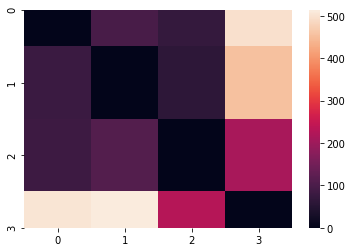

In [72]:
cm = confusion_matrix(y_test, y_pred)
for i in range(cm.shape[0]):
    for j in range(cm.shape[0]):
        if i == j:
            cm[i,j] = 0
sns.heatmap(cm)

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      4800
           1       0.85      0.88      0.87      4800
           2       0.92      0.91      0.92      4800
           3       0.75      0.74      0.75      4800

    accuracy                           0.85     19200
   macro avg       0.85      0.85      0.85     19200
weighted avg       0.85      0.85      0.85     19200



In [75]:
from sklearn.preprocessing import LabelEncoder

# Instantiating the encoder:
my_encoder = LabelEncoder()
my_encoder.fit(sketch_list)

for i, j in enumerate(my_encoder.classes_):
    print(f'{i}:{j}')

0:angel
1:sword
2:wine_glass
3:yoga


Class yoga had the lowest precision score (TP/(TP + FP). Class Yoga has a relatively high amount of false positives. 

Class yoga also has the lowest recall score (TP/(TP+FN)) and a majority of its false negatives comes from Class Sword.


## PCA VISUALIZATION

In [45]:
PCA_vis = PCA(n_components = 10)


X_PCA_scaled = PCA_vis.fit_transform(X_test_scaled)

(19200, 10)


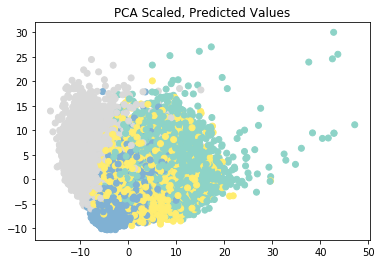

In [48]:
print(X_PCA_scaled.shape)
plt.figure()
plt.title("PCA Scaled, Predicted Values")
plt.scatter(X_PCA_scaled[:, 0], X_PCA_scaled[:, 1], c=y_pred, cmap = 'Set3')


(19200, 10)


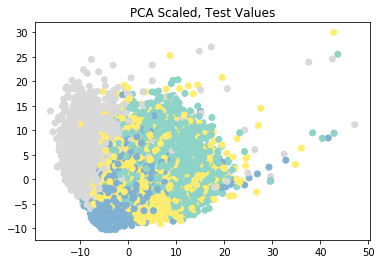

In [49]:
print(X_PCA_scaled.shape)
plt.figure()
plt.title("PCA Scaled, Test Values")
plt.scatter(X_PCA_scaled[:, 0], X_PCA_scaled[:, 1], c=y_test, cmap = 'Set3')
